In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.preprocessing import (OneHotEncoder, 
                                   LabelEncoder, 
                                   StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score,
                             f1_score, 
                             roc_curve,
                             auc, 
                             precision_recall_curve, 
                             classification_report, 
                             confusion_matrix, 
                             roc_auc_score)
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.proportion import proportion_confint

/Users/fainaburman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading adult dataset
df_train = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
     na_values='?', 
     header=None)

#loading test dataset
df_test = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
    na_values='?', 
    index_col=None)

In [3]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df_test.head()

,,,,,,,,,,,,,,|1x3 Cross validator
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [5]:
with open('/Users/fainaburman/Downloads/adult.names') as f:
    print(f.read())

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [6]:
def variable_type(df, v_type):
    variables = []
    for i in df.columns: 
        if df[i].dtypes == v_type:
            variables.append(i)
    return variables

In [7]:
#Data Cleaning
def clean_data(df):
    
    #column names
    col_labels = ['age',
                  'workclass',
                  'fnlwgt',
                  'education',
                  'education_num',
                  'marital_status',
                  'occupation',
                  'relationship',
                  'race',
                  'sex',
                  'capital_gain',
                  'capital_loss',
                  'hours_per_week',
                  'native_country', 
                  'income_>50K']        
    df.columns = col_labels
    
    #creating variable types
    object_variables = variable_type(df, 'object')
    num_variables = variable_type(df, 'int64')
    
    #removing extra spaces in non-numeric values
    for v in object_variables: 
        df[v] = df[v].replace('\s+', '', regex=True)
        
    #turning target variable into binary
    df_train['income_>50K'] = pd.get_dummies(df_train['income_>50K'],
                                             prefix='income_>50K',
                                             drop_first=True)
        
    return df, object_variables, num_variables

In [8]:
def check_missing_values(df): 
    #replace ? with NA
    df = df.apply(lambda x : x.replace('?',np.nan))
    
    count_missing = df.isnull().sum()
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing, 
                                     'count_missing': count_missing})
    
    #dropping NA vlues
    df.dropna(inplace=True)
    
    return df, missing_value_df

In [9]:
df_train, object_variables, num_variables = clean_data(df_train)
df_test, object_variables, num_variables = clean_data(df_test.reset_index())
df_train_cleaned, missing_value_df_train = check_missing_values(df_train)
df_test_cleaned, missing_value_df_test = check_missing_values(df_test)

In [10]:
df_train_cleaned.shape[0]/df_train.shape[0]

0.9263229016307853

## Missing Values 

`workclass`, `occupation`, and `native-country` each have under 6% of missing values, signified by `'?'`

Unknown values for `workclass` and `occupation` are almost perfectly correlated and could mean that the subjects were not willing to report this information. The total number of rows with missing values makes up under 10% of the sample, so we'll just drop the rows with missing values from the data set. 

Given more time, this could be another classification problem within the problem, to determine if the data is missing at random by classifying whether the observed data is missing or not base on the other features. Different imputation methods could be used if the data are not missing at random to account for the bias it might introduce into the model.

In [11]:
missing_value_df_train

,column_name,percent_missing,count_missing
age,age,0.000000,0
workclass,workclass,5.638647,1836
fnlwgt,fnlwgt,0.000000,0
education,education,0.000000,0
education_num,education_num,0.000000,0
marital_status,marital_status,0.000000,0
occupation,occupation,5.660146,1843
relationship,relationship,0.000000,0
race,race,0.000000,0
sex,sex,0.000000,0


In [12]:
missing_value_df_test

,column_name,percent_missing,count_missing
age,age,0.000000,0
workclass,workclass,5.914870,963
fnlwgt,fnlwgt,0.000000,0
education,education,0.000000,0
education_num,education_num,0.000000,0
marital_status,marital_status,0.000000,0
occupation,occupation,5.933296,966
relationship,relationship,0.000000,0
race,race,0.000000,0
sex,sex,0.000000,0


In [13]:
df_train_cleaned.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_>50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [14]:
df_test_cleaned.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_>50K
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [15]:
df_train_cleaned.shape

(30162, 15)

In [16]:
df_test_cleaned.shape

(15060, 15)

In [17]:
# checking the datatypes of all the columns in the data set
pd.DataFrame([df_train_cleaned.dtypes], 
             index = ['train_set']).T 

,train_set
age,int64
workclass,object
fnlwgt,int64
education,object
education_num,int64
marital_status,object
occupation,object
relationship,object
race,object
sex,object


In [18]:
pd.DataFrame([df_test_cleaned.dtypes], 
             index = ['test_set']).T 

,test_set
age,int64
workclass,object
fnlwgt,int64
education,object
education_num,int64
marital_status,object
occupation,object
relationship,object
race,object
sex,object


In [19]:
for v in object_variables:
    print(df_train_cleaned[v].value_counts())

Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: workclass, dtype: int64
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64
Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital_status, dtype: int64
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-ins

In [20]:
for v in num_variables:
    print(v, df_train_cleaned[v].max(), df_train[v].min())

age 90 17
fnlwgt 1484705 12285
education_num 16 1
capital_gain 99999 0
capital_loss 4356 0
hours_per_week 99 1


In [21]:
for v in object_variables:
    print(df_test_cleaned[v].value_counts())

Private             11021
Self-emp-not-inc     1297
Local-gov            1033
State-gov             667
Self-emp-inc          572
Federal-gov           463
Without-pay             7
Name: workclass, dtype: int64
HS-grad         4943
Some-college    3221
Bachelors       2526
Masters          887
Assoc-voc        652
11th             571
Assoc-acdm       499
10th             403
7th-8th          266
Prof-school      243
9th              221
12th             200
Doctorate        169
5th-6th          161
1st-4th           71
Preschool         27
Name: education, dtype: int64
Married-civ-spouse       6990
Never-married            4872
Divorced                 2083
Separated                 472
Widowed                   450
Married-spouse-absent     182
Married-AF-spouse          11
Name: marital_status, dtype: int64
Exec-managerial      1992
Craft-repair         1990
Prof-specialty       1970
Sales                1824
Adm-clerical         1819
Other-service        1596
Machine-op-inspct    

## Exploratory Data Analysis 

### Distributions

First we're going to look at the distribution of the variables. 

The data set is impbalanced in the following ways: 
 - The target variable is imbalanced in favor of not making 50K or above. 
 - `workclass='Private]'` value is dispropoportionately larger than the other values
 - `native_country='United-States'` values. This variable can be either ignore or replaced. with binary variable like from_united_states that will be equal to True if person from united states, and False otherwise.
 - There are more males than females in the sample
 - `'White'` is the predominant race in the sample
 - The hours_per_week has large spike at 40, which makes sense since it's the most common number of working hours per week for average person.
 - The capital_loss and capital_gain are also imbalanced and skew towards zero. 
 - The education_num column has two spikes. First spike around the number of years that it takes to complete school for the average person and the second one for university.

In [22]:
df_train_cleaned.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_>50K
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.248922
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.432396
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


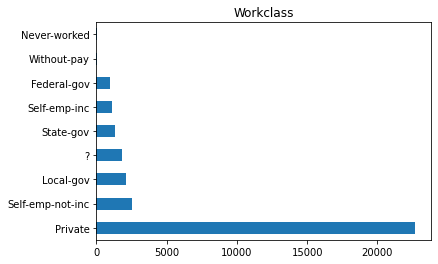

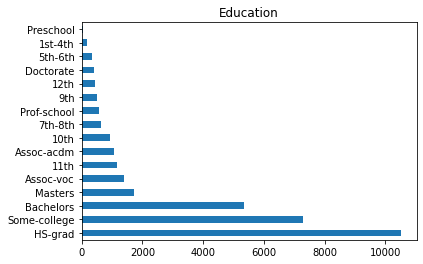

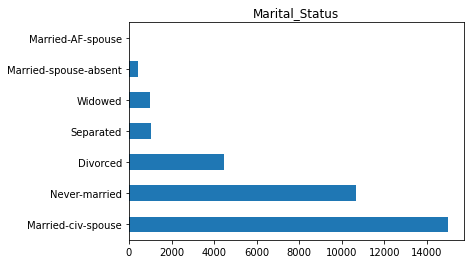

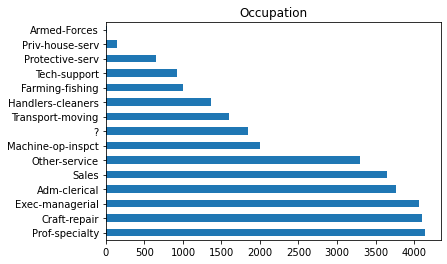

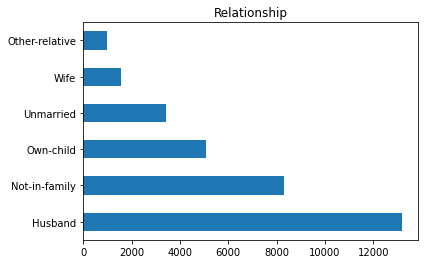

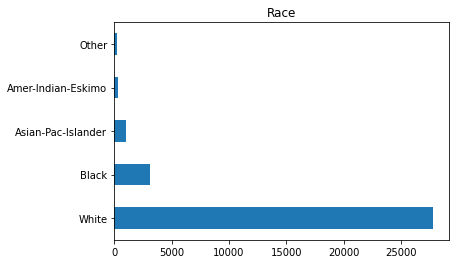

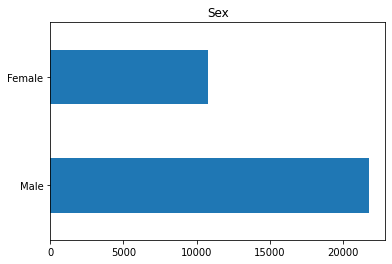

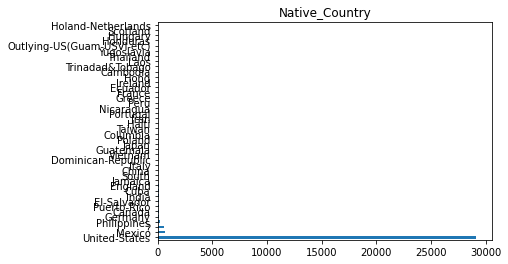

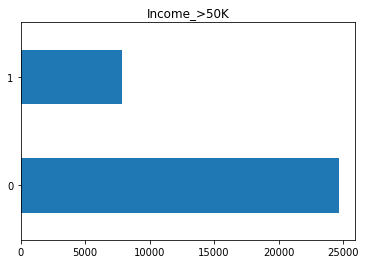

In [23]:
for feature in object_variables:
    plt.title(feature.title())
    (df_train[feature]
         .value_counts()
         .plot(kind='barh'))
    plt.show()

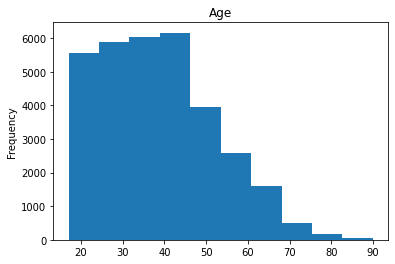

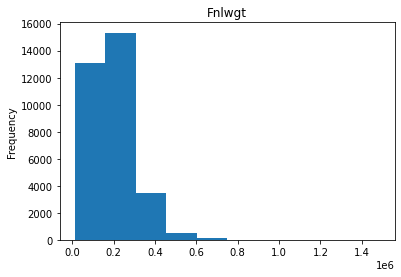

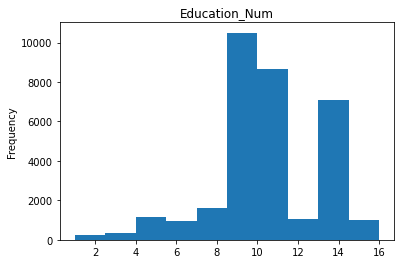

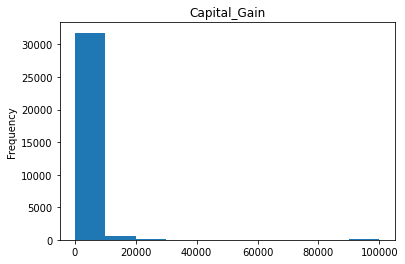

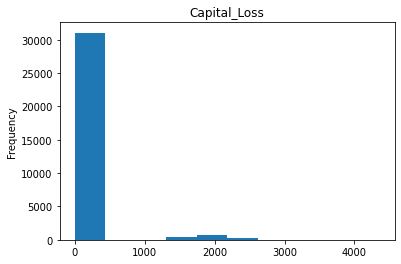

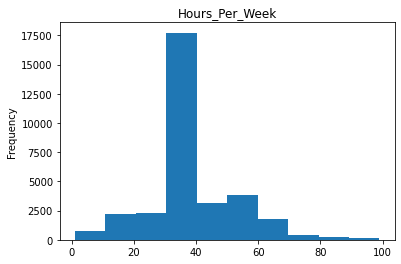

In [24]:
for feature, values in df_train[num_variables].iteritems():
    plt.title(feature.title())
    values.plot(kind='hist')
    plt.show()

<AxesSubplot:>

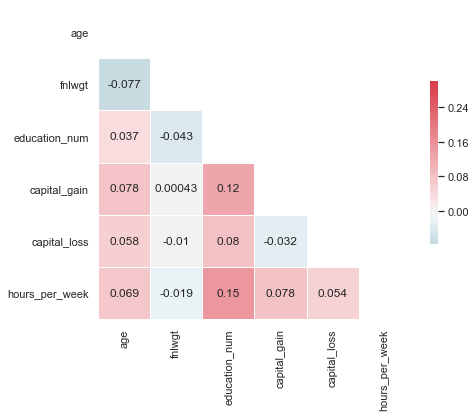

In [25]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_train[num_variables].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
            mask=mask, 
            cmap=cmap,
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            annot=True, 
            cbar_kws={"shrink": .5})


### Feature Relationship with The Outcome Variable

The outcome variable is a binary variable determining whether the subject's income is less than or equal to $50k or not. 

- Older respondents are more likely to make over 50k than younger ones
- Respondents with higher number of years of education are more likely to make over 50K
- Married respondents and those who identify as Husband or Wife in their relationship, are more likely to make over 50K, most likely due to joint income
- Respondents in Exec-Managerial and Prof-Specialty are more likely to make over 50K
- Respondents who work over 40 hours are more likely to make over 50k
- Men are more likely to make over 50k than women
- An Asian-Pac-Islander or a white person has more chances of earning more than 50K.
- Self-emp-in or Federal-gov workclass groups have a higher chance of earning more than 50K.

By looking at statistical associations on the feature values with the outcome varible, we can bucket the values for more predictive feature engineering. 




In [26]:
def plot_income_vs_variables(df):
    for feature in df.columns:
        salary_50k_false = df.loc[df['income_>50K'] == 0, 
                                  feature]
        salary_50k_true = df.loc[df['income_>50K'] == 1,
                                 feature]
        salary_50k_false_stats = salary_50k_false.value_counts()
        salary_50k_true_stats = salary_50k_true.value_counts()

        if feature in num_variables:
            plt.title(feature.title())
            plt.hist(salary_50k_false, 
                     bins=20, 
                     density=True, 
                     alpha=0.5)
            plt.hist(salary_50k_true, 
                     bins=40, 
                     density=True, 
                     alpha=0.5)
            xmin, xmax = plt.xlim()
            plt.xlim(0, xmax)
            plt.xlabel(feature.title())

        else: 
            low_bar = plt.barh(
            salary_50k_false_stats.index,
            salary_50k_false_stats.values / salary_50k_false_stats.values.sum(),
            alpha=0.5,
            )
            high_bar = plt.barh(
                salary_50k_true_stats.index,
                salary_50k_true_stats.values / salary_50k_true_stats.values.sum(),
                alpha=0.5,
            )
            plt.xlabel('Fraction')
            

        plt.legend(df['income_>50K'].unique())
        plt.title(feature.title())
        plt.show()
        

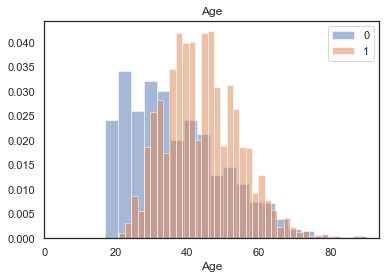

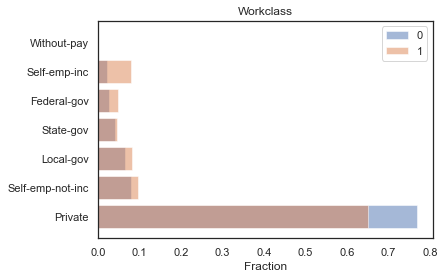

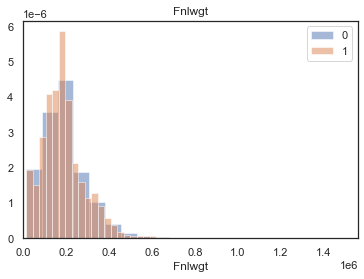

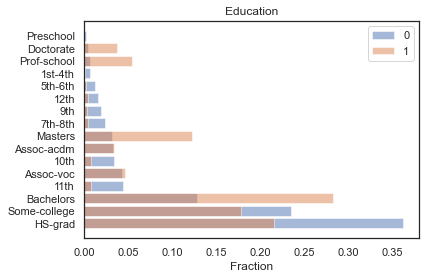

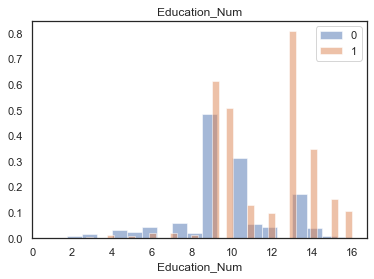

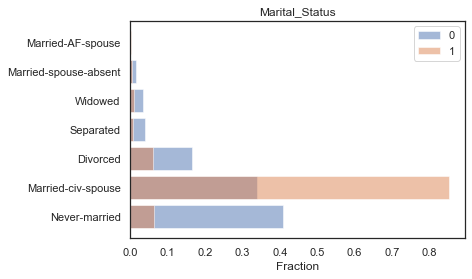

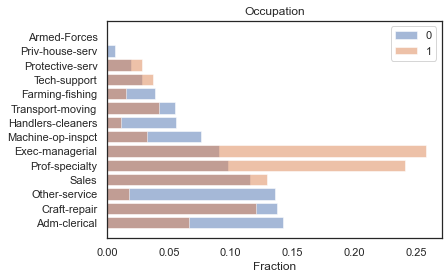

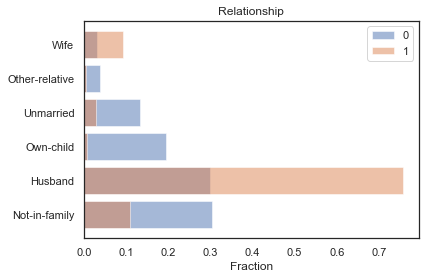

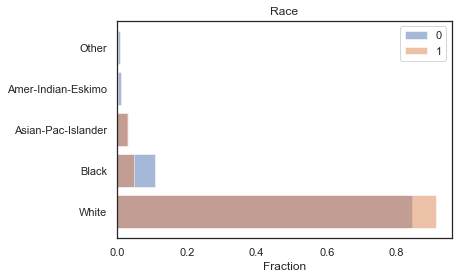

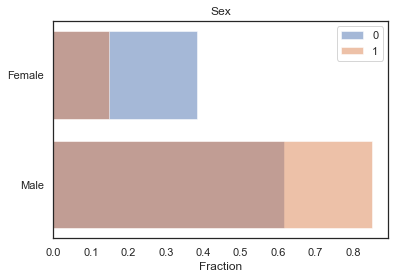

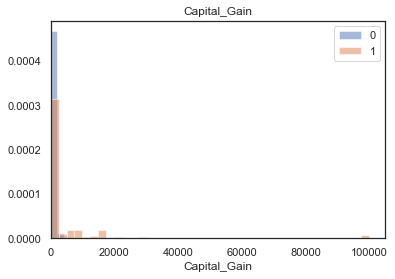

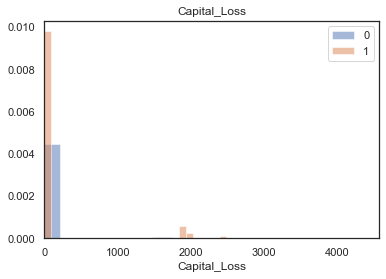

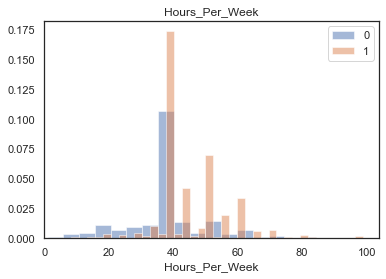

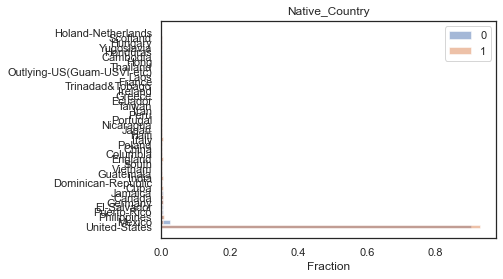

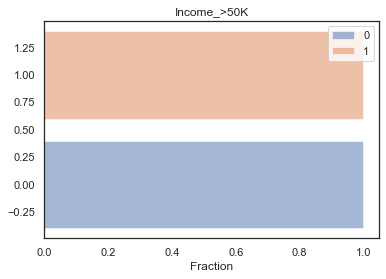

In [27]:
plot_income_vs_variables(df_train_cleaned)

In [28]:
def explore_categorical_feature(var, 
                                df, 
                                target = 'income_>50K', 
                                ci_alpha=0.05):
    # This function performs a deeper exploration of the categorical features
    cat_explore = pd.concat([df[var].value_counts(), 
                             df[var].value_counts()/df.shape[0], 
                             df.groupby(var)[target].mean()], 
                            axis=1, 
                            sort=False, 
                            keys=['Count', 
                                  'Share', 
                                  'Positive Rate'])
    cat_explore.index.name = var    
    cat_explore['ci'] = cat_explore.apply(lambda x: proportion_confint(x['Count'] * x['Positive Rate'], 
                                                                       x['Count'],
                                                                       alpha=ci_alpha, 
                                                                       method='jeffreys'),  axis = 1)
    cat_explore['Conf Interval Lower'] = cat_explore['ci'].apply(lambda x: x[0])
    cat_explore['Conf Interval Upper'] = cat_explore['ci'].apply(lambda x: x[1])  
    return cat_explore.drop(['ci'],
                            axis=1).sort_values('Count', ascending = False)

In [29]:
for v in object_variables: 
    print(explore_categorical_feature(v, df_train_cleaned))

                  Count     Share  Positive Rate  Conf Interval Lower  \
workclass                                                               
Private           22286  0.738877       0.218792             0.213401   
Self-emp-not-inc   2499  0.082853       0.285714             0.268258   
Local-gov          2067  0.068530       0.294630             0.275275   
State-gov          1279  0.042404       0.268960             0.245201   
Self-emp-inc       1074  0.035608       0.558659             0.528838   
Federal-gov         943  0.031265       0.387063             0.356359   
Without-pay          14  0.000464       0.000000             0.000034   

                  Conf Interval Upper  
workclass                              
Private                      0.224256  
Self-emp-not-inc             0.303667  
Local-gov                    0.314560  
State-gov                    0.293764  
Self-emp-inc                 0.588165  
Federal-gov                  0.418458  
Without-pay           

## Feature Engineering

- `'fnlwgt'` - weight from the research, to be removed
- `'education_num'` corresponds to education, so we'll drop the education feature a and keep the education_num
- `'net_gain'` will be used as the feature that combines `'net_gain'` and `'net_loss'`
- `'higher_ed'` will check whether the respondent is in the 3 higher earching education buckets
- `'high_income_age'` will check whether the respondent is betweeb 35 and 55 years old, which is the age when the respondents are more likely to earn over 50K
- `'working_more_than_40'` breaks up work hours into 3 categories
- `'high_pay_occupation'` checks is the respondent is a member of high earning professions, 'Prof-specialty' or'Exec-managerial'])
- `'is_US'` turns country into a binary variable, since the samples sizes for other countries are too small to be meaningful
- `'husband_wife'` checks if the responent is in one of those two higher earning categories, which contribute to higher (dual) income
- We're going to one-hot-code categorical variables and scale the numerical variables 

In [30]:
#checking if the relationship is one to one 
def edu(x):
    x['num_status'] = (x['education'], x['education_num'])
    return x

copy = df_train.copy().apply(lambda x: edu(x), axis=1)
print(np.sort(copy['num_status'].unique()))

[('10th', 6) ('11th', 7) ('12th', 8) ('1st-4th', 2) ('5th-6th', 3)
 ('7th-8th', 4) ('9th', 5) ('Assoc-acdm', 12) ('Assoc-voc', 11)
 ('Bachelors', 13) ('Doctorate', 16) ('HS-grad', 9) ('Masters', 14)
 ('Preschool', 1) ('Prof-school', 15) ('Some-college', 10)]


In [31]:
def high_income_age(row):
    work_age = range(35,55)
    return int(work_age.count(row['age']))

def working_more_than_40(row):
    if row['hours_per_week'] < 40:
        return 0
    elif row['hours_per_week'] ==40 :
        return 1
    elif row['hours_per_week'] > 40:
        return 2

def scale_num_variables(df, num_variables):  
    features = df[num_variables]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[num_variables] = features
    return df
    
def transform_cat_variables(df, object_variables):
    for col in object_variables:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df
        
def make_new_features(df):
    df['net_gain'] = df['capital_gain'] - df_train['capital_loss']
    df['higher_ed'] = df.education_num.isin([14,15,16])
    df['high_income_age'] = df.apply(high_income_age, axis=1)
    df['working_more_than_40'] = df.apply(working_more_than_40, axis = 1)
    df['high_pay_occupation'] = df.occupation.isin(['Prof-specialty','Exec-managerial'])
    df['is_US'] = df.native_country.isin(['United-States'])
    df['husband_wife'] = df['relationship'].map(lambda x: int((x =='Husband') | (x == 'Wife') )) 
    df = scale_num_variables(df, num_variables + ['net_gain'])
    df = transform_cat_variables(df, object_variables)
    df.drop(['fnlwgt', 
             'capital_gain',
             'capital_loss', 
             'education', 
             'native_country'], 
            axis=1, 
            inplace=True) 
    return df

In [32]:
df_train_k = make_new_features(df_train_cleaned)
df_train_k.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income_>50K,net_gain,higher_ed,high_income_age,working_more_than_40,high_pay_occupation,is_US,husband_wife
0,0.042796,5,1.128918,4,0,1,4,1,-0.077734,0,0.157514,False,1,1,False,True,0
1,0.880288,4,1.128918,2,3,0,4,1,-2.331531,0,-0.135074,False,1,0,True,True,1
2,-0.033340,2,-0.439738,0,5,1,4,1,-0.077734,0,-0.135074,False,1,1,False,True,0
3,1.108695,2,-1.224066,2,5,0,2,1,-0.077734,0,-0.135074,False,1,1,False,True,1
4,-0.794697,2,1.128918,2,9,5,2,0,-0.077734,0,-0.135074,False,0,1,True,False,1


In [33]:
df_test_k = make_new_features(df_test_cleaned)
df_test_k.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income_>50K,net_gain,higher_ed,high_income_age,working_more_than_40,high_pay_occupation,is_US,husband_wife
0,-1.029005,2,-1.216563,4,6,3,2,1,-0.078889,0,-0.133736,False,0,1,False,True,0
1,-0.057423,2,-0.434898,2,4,0,4,1,0.750131,0,-0.133736,False,1,2,False,True,1
2,-0.804794,1,0.737599,2,10,0,4,1,-0.078889,1,-0.133736,False,0,1,False,True,1
3,0.391000,2,-0.044066,2,6,0,2,1,-0.078889,1,0.862526,False,1,1,False,True,1
5,-0.356371,2,-1.607395,4,7,1,4,1,-0.907909,0,-0.133736,False,0,0,False,True,0


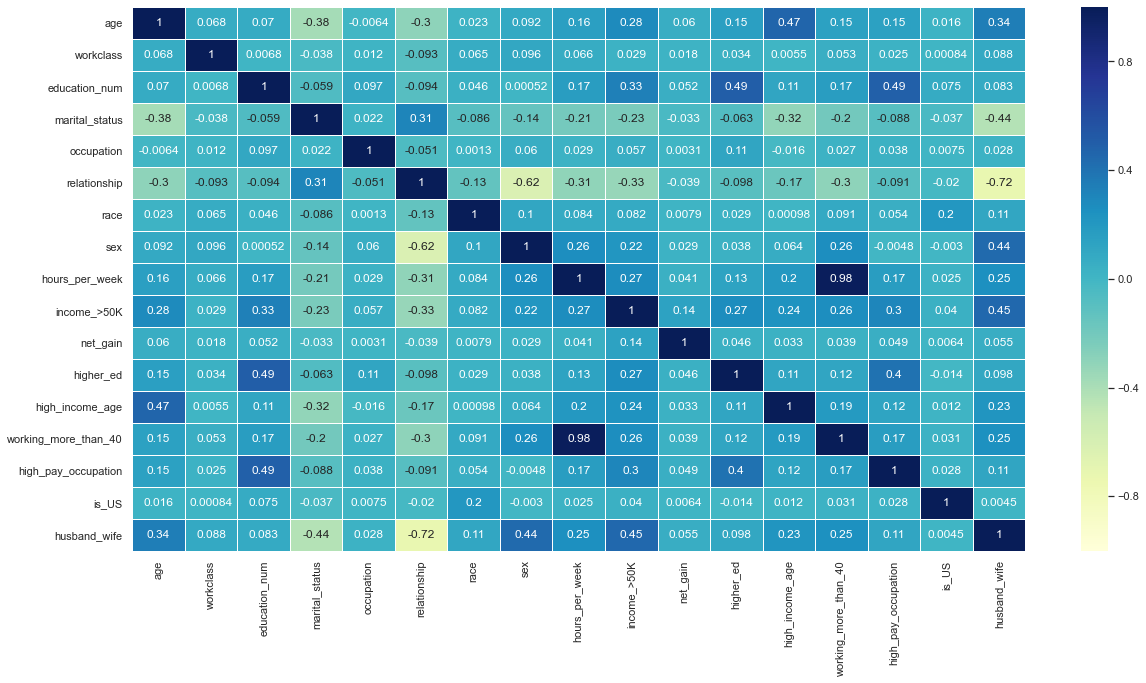

In [34]:
#Check corr
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df_train_k.corr(method='spearman'), 
            vmax=1,
            vmin=-1, 
            annot=True, 
            linewidths=.8, 
            cmap='YlGnBu');

## Model Building

Since this is a classification problem, we are going to try out 3 different models: 
- Logistic Regression - is the simplest way to calculate the probablity of a binary outcome
- KNeighbors Classifier - this algorithm works by recognizing patterns and it uses the data in the training set to find the k closest relatives in the data it predicts. 
- Random Forest averages your data to connect it to the nearest tree on the data scale. Random forest are a type of decision tree and thet solve decision tree’s problem of making data points choose a category unnecessarily

There are other algorithms we can try to solve this problem as well. 

The baseline percentage of a respondent making over 50k from the the provided dataset is 25%.

In [35]:
def split_data(df):
    X = df_train_k.drop(['income_>50K'], axis=1)
    y = df_train_k[['income_>50K']]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.25, 
                                                        stratify=y['income_>50K'], 
                                                        random_state=42)

    return(X, 
           y, 
           X_train,
           X_test, 
           y_train, 
           y_test)


In [36]:
(X, 
 y,
 X_train,
 X_test, 
 y_train, 
 y_test) = split_data(df_train_k)
#baseline rate for respondents who make over 50K is 25%
print(y['income_>50K'].value_counts()[1]/len(y['income_>50K']), 
      X_train.shape,
      X_test.shape, 
      y_train.shape, 
      y_test.shape)

0.24892248524633645 (22621, 16) (7541, 16) (22621, 1) (7541, 1)


In [37]:
def train_and_predict_model(X_train,
                            X_test, 
                            y_train, 
                            y_test, 
                            model, 
                            success_metric=accuracy_score):
    model_results = {}
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    model_results['y_pred'] = y_pred
    model_results['y_test'] = y_test
    model_results['metric'] = success_metric(y_test, y_pred)
    model_results['y_pred_probas'] = model.predict_proba(X_test)
    print(model)
    print("Distribution:")
    print( pd.Series(y_pred).value_counts())
    return model_results

In [38]:
models = {}
models['logistic_regression'] = LogisticRegression(random_state=0, max_iter=500)
models['random_forest'] = RandomForestClassifier(max_depth = 9, n_estimators = 40, random_state=2019)
models['knn'] = KNeighborsClassifier(n_neighbors=100, weights='distance')
models_dic = {}
for key in models.keys(): 
    model = models[key]
    models_dic[key] = train_and_predict_model(X_train, X_test, y_train, y_test, model)

LogisticRegression(max_iter=500, random_state=0)
Distribution:
0    6102
1    1439
dtype: int64
RandomForestClassifier(max_depth=9, n_estimators=40, random_state=2019)
Distribution:
0    6178
1    1363
dtype: int64
KNeighborsClassifier(n_neighbors=100, weights='distance')
Distribution:
0    6097
1    1444
dtype: int64


## Model Evaluation

Each of the models gets a confusion metrics dataframe so we can use it to evaluate the model.

Random Forest model has the highest accuracy (85%) and percision score (78%), and has the best learning curve, where the training score and the cross-validation score are actually starting to get closer to converging with the increased number of sample observations. It's not overfitting the data like the Logistic Regression model, and the gap isn't as large as with KNN.  


In [39]:
def create_confusion_matrix(y_test, y_pred):
    conmat = confusion_matrix(y_test, y_pred)
    condf = pd.DataFrame(columns=['Actually Positive',
                                  'Actually Negative'], index=['Predicted Positive', 
                                                               'Predicted Negative'])

    for i in range(2):
        for j in range(2):
            condf.iloc[i, j] = conmat.T[(1-i), (1-j)]
    return condf

In [40]:
confusion_matrices = {}
for model in models_dic.keys():
    confusion_matrices[model] = create_confusion_matrix(models_dic[model]['y_test'], 
                                                        models_dic[model]['y_pred'])

In [41]:
confusion_matrices['logistic_regression'] 

,Actually Positive,Actually Negative
Predicted Positive,1043,396
Predicted Negative,834,5268


In [42]:
confusion_matrices['random_forest'] 

,Actually Positive,Actually Negative
Predicted Positive,1066,297
Predicted Negative,811,5367


In [43]:
confusion_matrices['knn'] 

,Actually Positive,Actually Negative
Predicted Positive,1020,424
Predicted Negative,857,5240


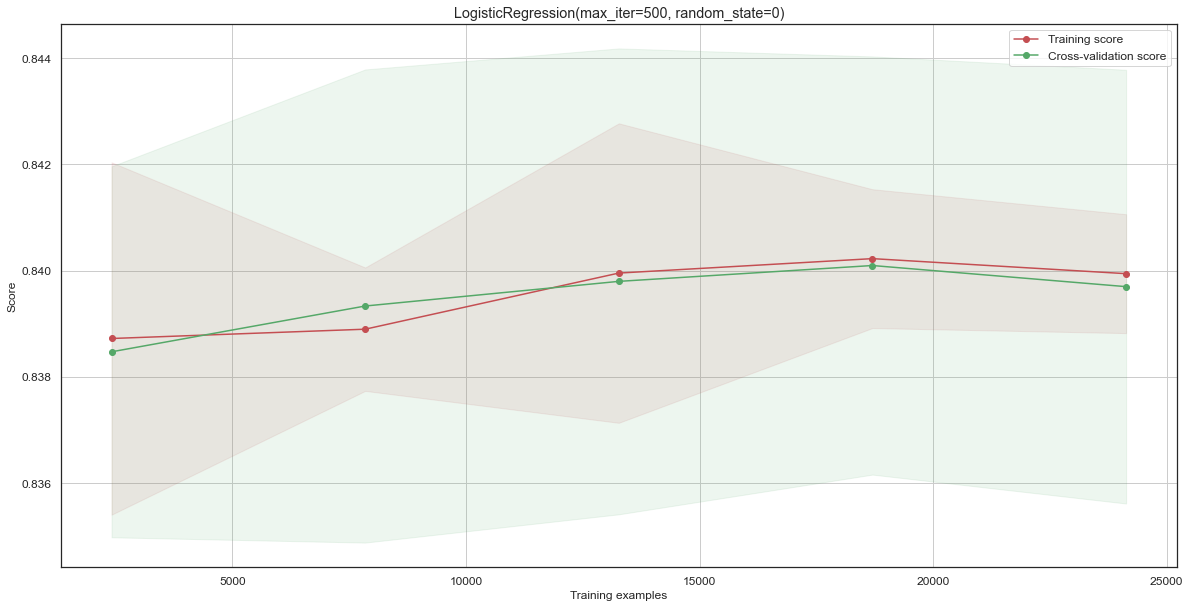

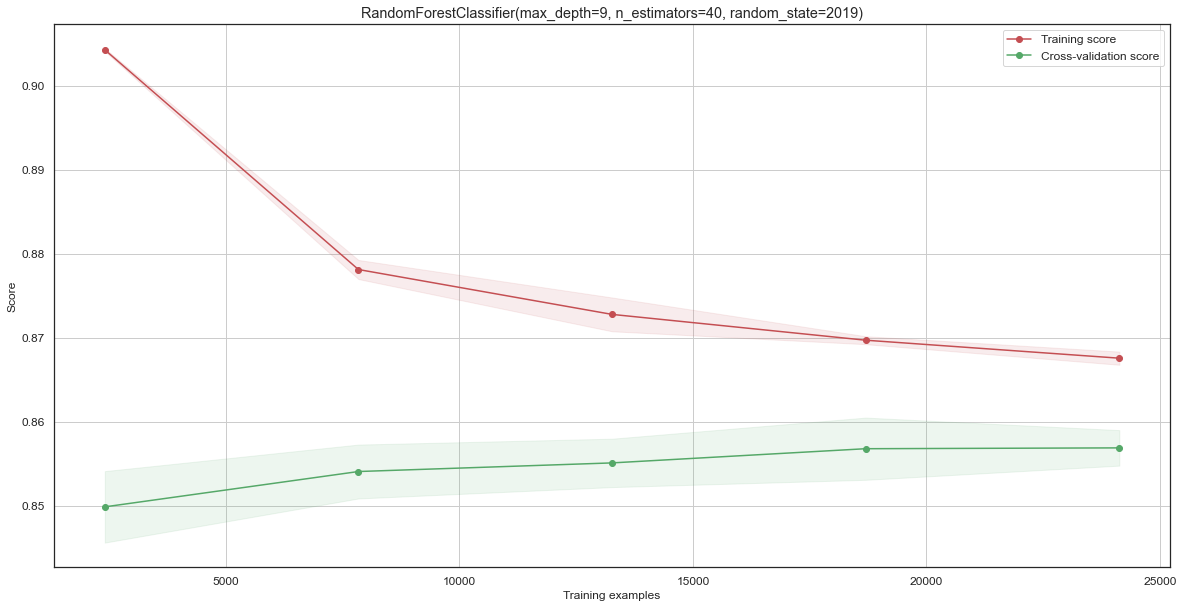

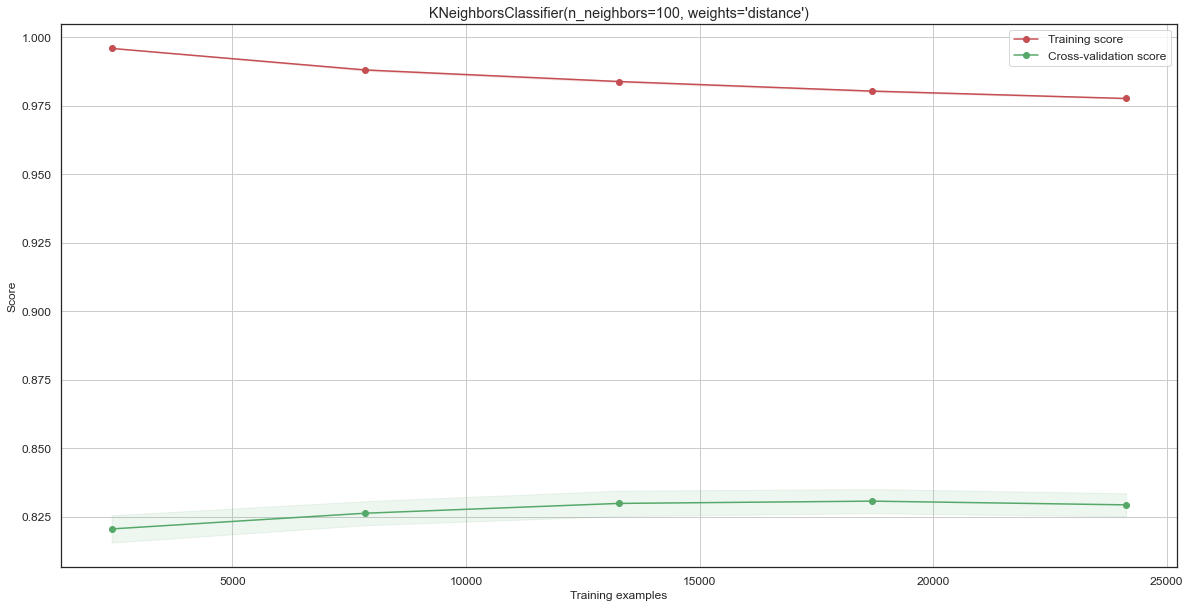

In [44]:
for model in models.values():
    skplt.estimators.plot_learning_curve(model, 
                                         X, 
                                         y.values.ravel(),
                                         cv=5, 
                                         title=model)

In [45]:
def create_metrics(y_test, y_pred):
    metrics = {'Metric':['precision_score', 
                         'accuracy_score', 
                         'recall_score', 
                         'f1_score'],
               'Score':[accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred),
                        f1_score(y_test, y_pred)]}


    # Create DataFrame
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [46]:
metrics = {}
for model in models.keys():
    metrics[model] = create_metrics(models_dic[model]['y_test'], 
                                    models_dic[model]['y_pred'])

In [47]:
metrics['logistic_regression']

,Metric,Score
0,precision_score,0.836892
1,accuracy_score,0.724809
2,recall_score,0.555674
3,f1_score,0.629071


In [48]:
metrics['random_forest']

,Metric,Score
0,precision_score,0.853070
1,accuracy_score,0.782098
2,recall_score,0.567928
3,f1_score,0.658025


In [49]:
metrics['knn']

,Metric,Score
0,precision_score,0.830129
1,accuracy_score,0.706371
2,recall_score,0.543420
3,f1_score,0.614273


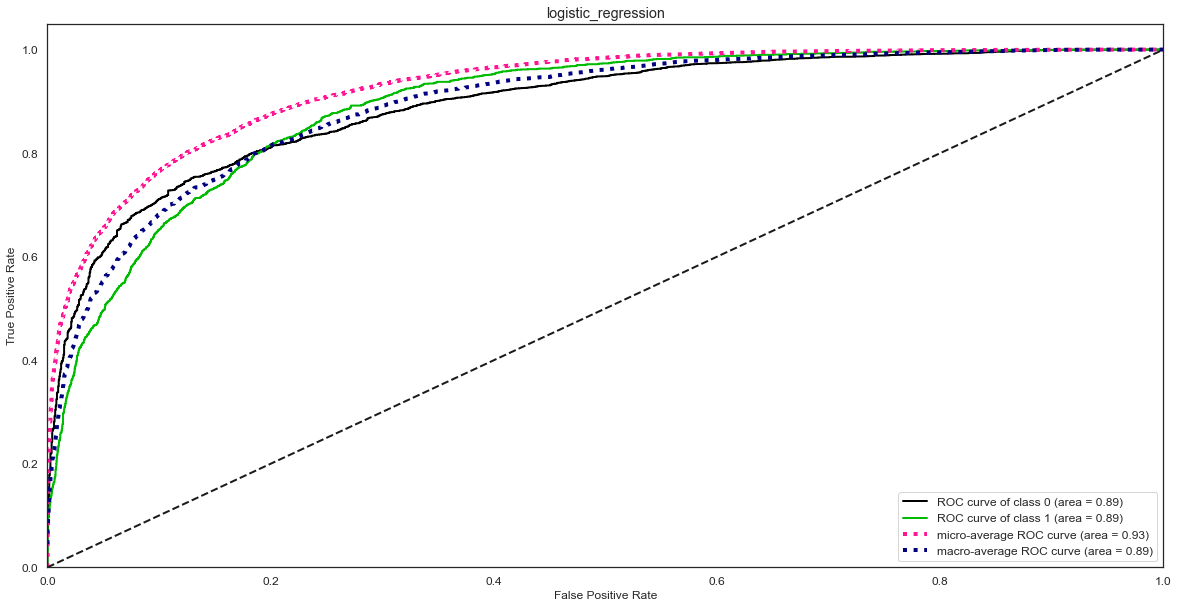

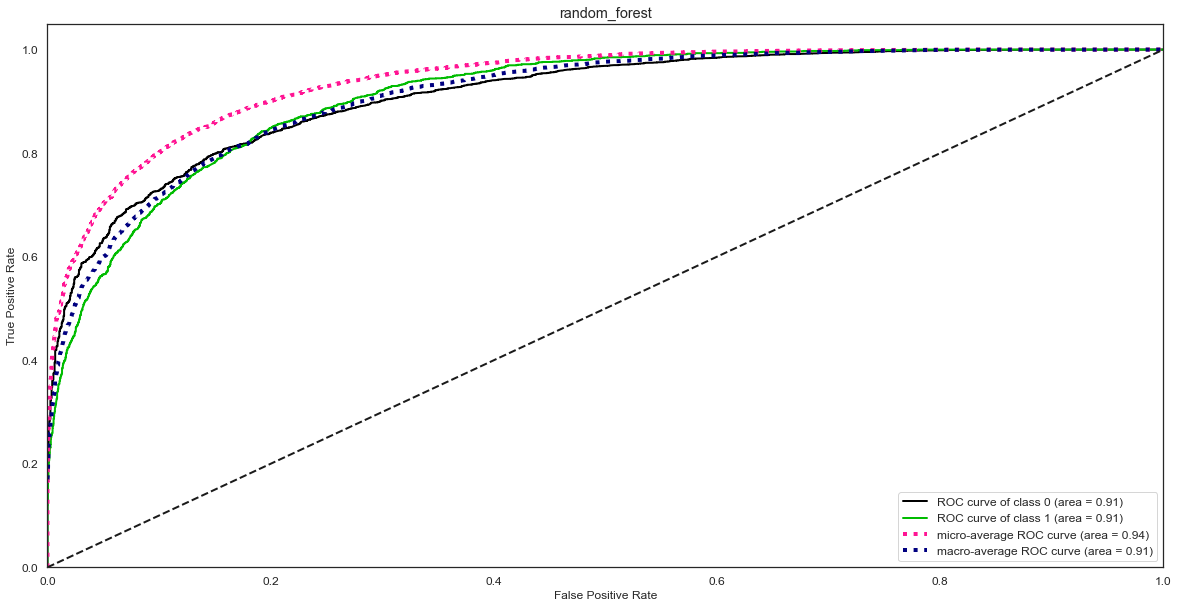

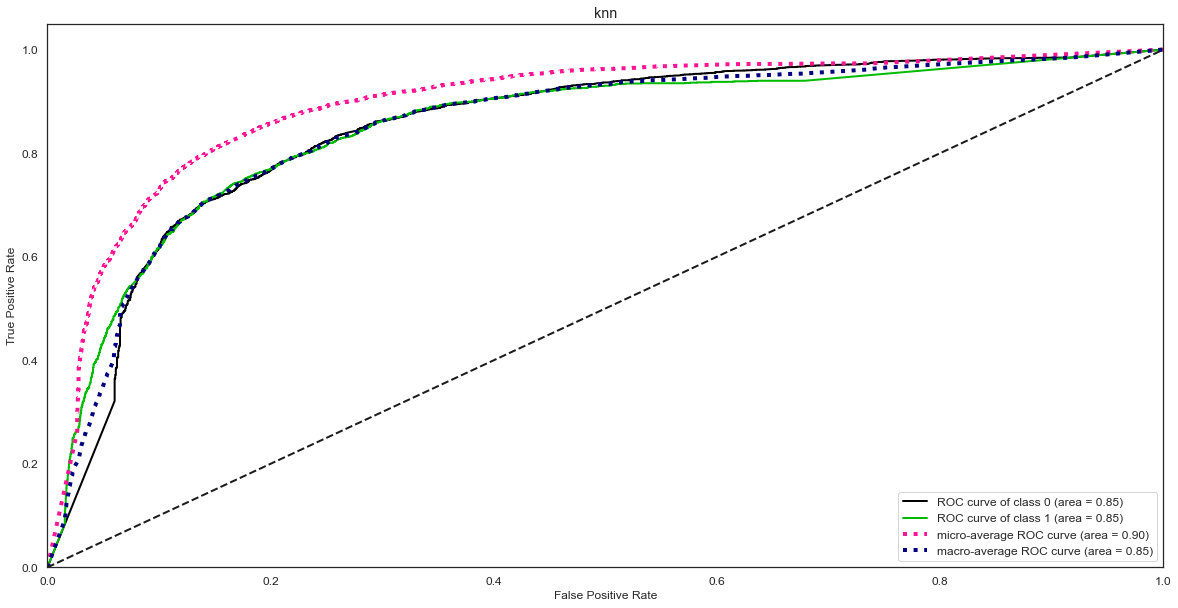

In [50]:
for model in models.keys():
    skplt.metrics.plot_roc(models_dic[model]['y_test'],
                           models_dic[model]['y_pred_probas'], 
                           title=model)

## Feature Selection

Having selected the Random Forest model, we can look at the feature importance graph in order to reduce the number of features and remove the ones that aren't contibuting much to the model's performance. 

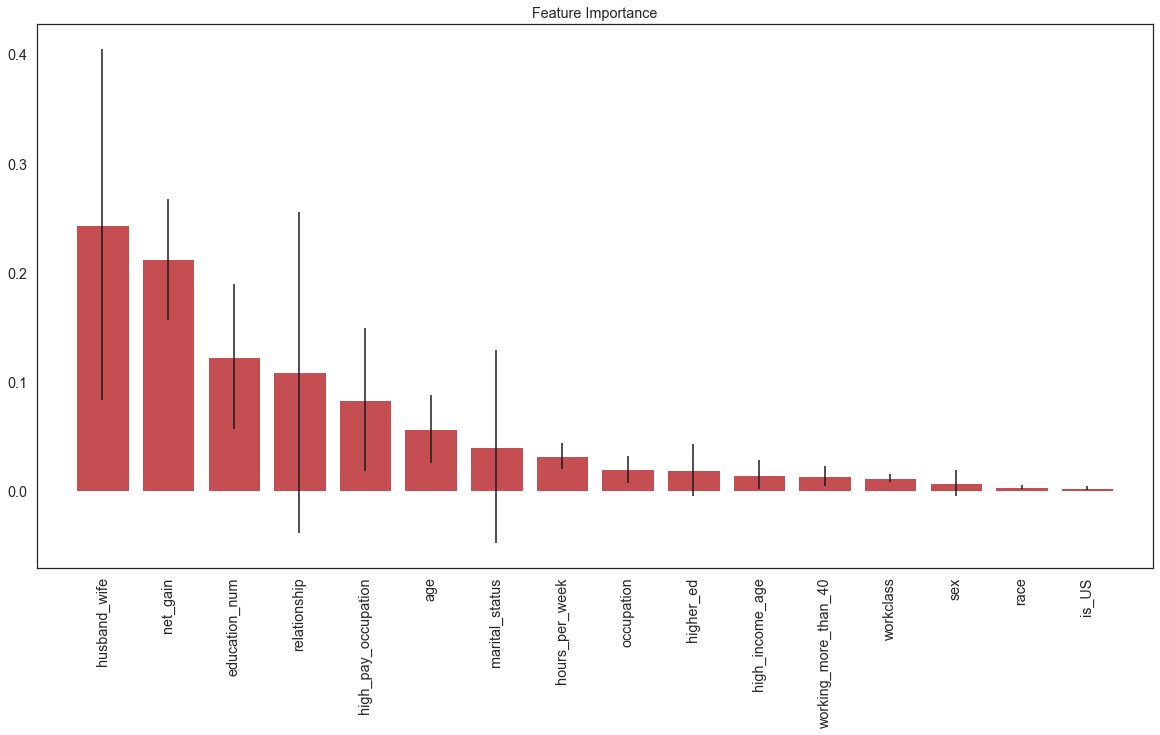

In [51]:
model = models['random_forest']
features = X.columns.values
skplt.estimators.plot_feature_importances(model, 
                                          feature_names=features, 
                                          x_tick_rotation=90, 
                                          text_fontsize='large' ); 

In [52]:
variables_to_drop = ['is_US', 
                     'race',
                     'sex', 
                     'workclass', 
                     'working_more_than_40', 
                     'high_income_age', 
                     'higher_ed',  
                     'relationship',
                     'marital_status']

## Prediction For Test Data

The following section uses the updated model to predict whether the respondents makes 50k+ in the test dataset. The positivity rate is consistent with the baseline of ~25%, and the evaluation metrics are on par with the previous version of the model, even with the reduced number of fratures. 

Given more time, hyperparameter turning could produce a more accurate model. 

In [53]:
model = models['random_forest']
X_train = X_train.drop(variables_to_drop, axis=1)
X_test = df_test_k.drop(variables_to_drop + ['income_>50K'], axis=1)
y_test = df_test_k[['income_>50K']]           
results = train_and_predict_model(X_train,
                                  X_test, 
                                  y_train, 
                                  y_test, 
                                  model)

RandomForestClassifier(max_depth=9, n_estimators=40, random_state=2019)
Distribution:
0    12394
1     2666
dtype: int64


In [54]:
create_metrics(results['y_test'], 
               results['y_pred'])

,Metric,Score
0,precision_score,0.847012
1,accuracy_score,0.761815
2,recall_score,0.548919
3,f1_score,0.638077


In [55]:
df_test_k['y_pred'] = results['y_pred']
df_test_k['y_pred_proba'] = results['y_pred_probas'][ :, 1 ]
df_test_k['y_test'] = results['y_test']
df_test_k['is_correct'] = (df_test_k['y_pred'] == df_test_k['y_test'])
df_test_k.to_csv('adult_test_predicted.csv')
df_test_k.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income_>50K,...,higher_ed,high_income_age,working_more_than_40,high_pay_occupation,is_US,husband_wife,y_pred,y_pred_proba,y_test,is_correct
0,-1.029005,2,-1.216563,4,6,3,2,1,-0.078889,0,...,False,0,1,False,True,0,0,0.003815,0,True
1,-0.057423,2,-0.434898,2,4,0,4,1,0.750131,0,...,False,1,2,False,True,1,0,0.343693,0,True
2,-0.804794,1,0.737599,2,10,0,4,1,-0.078889,1,...,False,0,1,False,True,1,0,0.306700,1,False
3,0.391000,2,-0.044066,2,6,0,2,1,-0.078889,1,...,False,1,1,False,True,1,1,0.965703,1,True
5,-0.356371,2,-1.607395,4,7,1,4,1,-0.907909,0,...,False,0,0,False,True,0,0,0.007833,0,True


In [56]:
df_test_k['y_test'].sum()/df_test_k['y_test'].count()

0.2456839309428951